### In this notebook, I try to add stellar mass and redshift into $\vec{\theta}$, plus noise into the data and forward models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [106]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)
speculator.network.eval();

In [107]:
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [108]:
# y_test = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=3000)
y_test1 = np.random.multivariate_normal(mean=[6, -1], cov=[[0.7, 0.], [0., 0.2]], size=2500)
y_test2 = np.random.multivariate_normal(mean=[5, 1.5], cov=[[0.7, 0.], [0., 0.3]], size=2500)
#y_test2 = np.random.multivariate_normal(mean=[6, 0], cov=[[-0.7, 0.3], [0.3, -0.1]], size=1500)
y_test = np.vstack([y_test1, y_test2])
y_stellar_mass = torch.normal(10, 0.4, size=(len(y_test), 1)).to('cuda')
y_redshift = torch.normal(0.1, 0.02, size=(len(y_test), 1)).to('cuda')
#torch.ones(size=(len(y_test), 1)).to('cuda') * 10.0 
y_test = Tensor(y_test).to('cuda')
x_test = speculator.predict_mag(y_test, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=noise, noise_model_dir=noise_model_dir,
                               ).cpu().detach().numpy()
x_test = Tensor(x_test).to('cuda')

x_test_clean = speculator.predict_mag(y_test, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=None,
                               ).cpu().detach().numpy()
x_test_clean = Tensor(x_test_clean).to('cuda')

# figure = corner.corner(np.hstack([y_test.cpu().detach().numpy(), 
#                                   y_stellar_mass.cpu().detach().numpy(),
#                                   y_redshift.cpu().detach().numpy()]), 
#                        quantiles=[0.16, 0.5, 0.84], 
#                        labels=['tage', 'log tau', 'log M*', 'redshift'],
#                        smooth=0.7,
#                        show_titles=True, 
#                        title_kwargs={"fontsize": 12}, 
#                        hist_kwargs={'density': True})

In [109]:
torch.std(x_test - x_test_clean, axis=0)

tensor([0.1985, 0.0265, 0.0255, 0.0295, 0.0696], device='cuda:0')

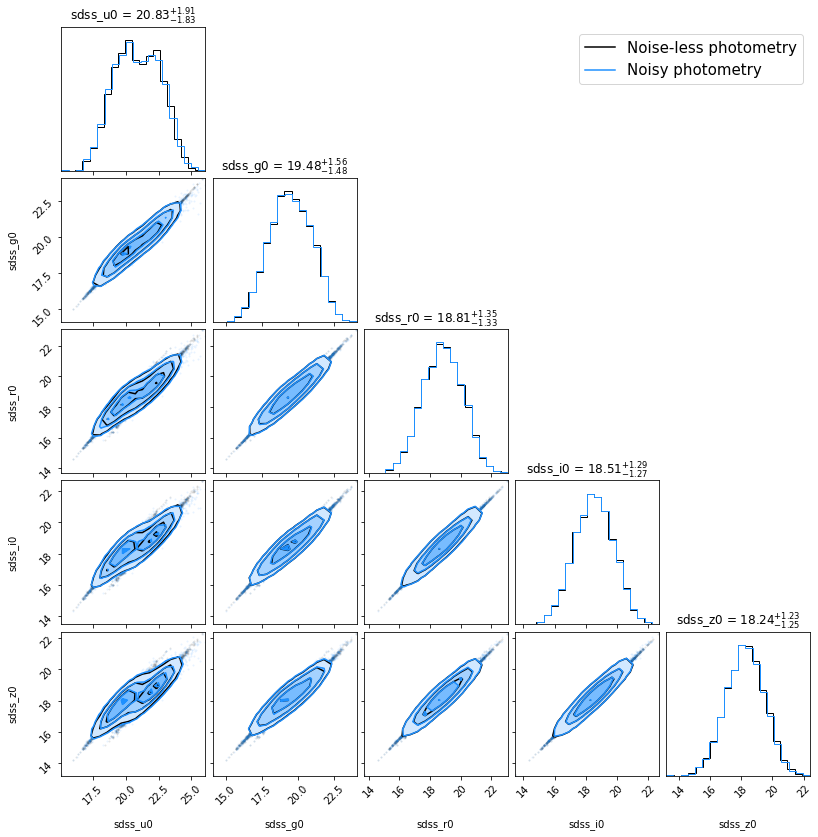

In [110]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test_clean.cpu().detach().numpy()[:, :], 
                       color='k', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

nf_plot = corner.corner(x_test.cpu().detach().numpy()[:, :], 
                        color='dodgerblue', fig=figure, labels=labels,
                        #quantiles=[0.16, 0.5, 0.84], 
                        smooth=0.7, fill_contours=True,
                        show_titles=True, 
                        title_kwargs={"fontsize": 12},
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [111]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [112]:
Y_truth = torch.hstack([y_test, y_stellar_mass, y_redshift])

In [115]:
for i in range(10):
    NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=10, 
                                                  num_bins=50, hidden_features=120,
                                                  output_dir='./nde_theta_SNR10_new/')
    NDE_theta.build(
        Y_truth, 
        x_test,
        optimizer='adam')
    NDE_theta.train(n_epochs=50, n_samples=5000, lr=2e-3,
                    speculator=speculator, 
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={'p': 2, 'blur': 0.01, 'scaling': 0.8},
                   )
    NDE_theta.train(n_epochs=50, n_samples=5000, lr=1e-3,
                    speculator=speculator, 
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={'p': 2, 'blur': 0.01, 'scaling': 0.8},
                   )
    NDE_theta.train(n_epochs=50, n_samples=5000, lr=5e-4,
                    speculator=speculator, 
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={'p': 2, 'blur': 0.01, 'scaling': 0.8},
                   )

Loss = -2.111: 100%|███████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70epochs/s]


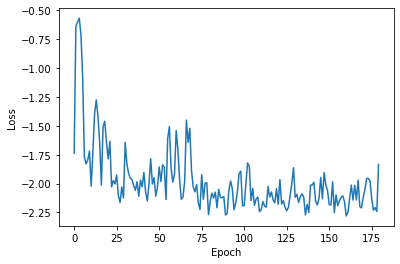

In [96]:
NDE_theta.plot_loss()

In [97]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])

Best epoch: 161
Best loss: -2.279667854309082


In [98]:
# with open(f'./nde_theta_best_loss_nsf_{NDE_theta.index}.pkl', 'rb') as f:
#     NDE_theta = pickle.load(f)

In [99]:
NDE_theta.best_model.goodness_of_fit(Y_truth)

Log10 Wasserstein distance in theta space:  -0.7745405575465474


In [103]:
samples = NDE_theta.best_model.sample(5000)

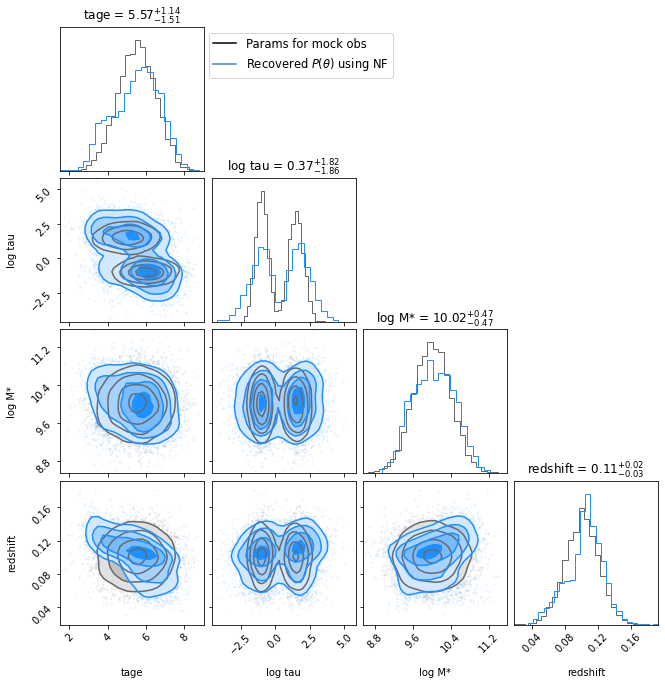

In [104]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*', 'redshift']

figure = corner.corner(np.hstack([y_test.cpu().detach().numpy(), 
                                  y_stellar_mass.cpu().detach().numpy(),
                                  y_redshift.cpu().detach().numpy()]), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

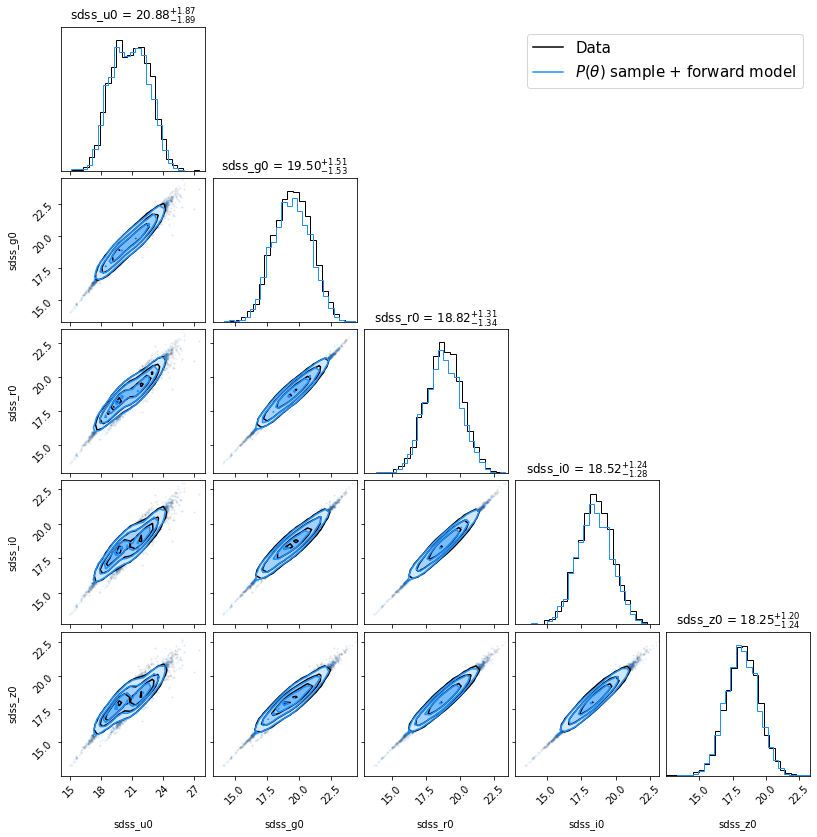

In [105]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(speculator._predict_mag_with_mass_redshift(samples, 
                                                                   noise=noise, 
                                                                   noise_model_dir=noise_model_dir,
                                                                  ).cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))